<a href="https://colab.research.google.com/github/Rogerx98/twsm-group-project/blob/main/SentenceBERT_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Comment:

Inspiration 1 for Multi-label: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb

Inspiration 2 for MultiLabelBinarizer = https://github.com/pnageshkar/NLP/blob/master/Medium/Multi_label_Classification_BERT_Lightning.ipynb

# **Libraries**

In [2]:
!pip install transformers 
!pip install bs4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 15.0 MB/s 
     |████████████████████████████████| 101 kB 7.0 MB/s 
     |████████████████████████████████| 6.6 MB 12.0 MB/s 
     |████████████████████████████████| 596 kB 59.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import re

# Huggingface transformers
import transformers
from transformers import BertModel,BertTokenizer,AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import MultiLabelBinarizer

from bs4 import BeautifulSoup

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import BertForSequenceClassification

import tensorflow as tf

np.set_printoptions(formatter={'float_kind':'{:f}'.format})
#since most of our numbers will be decimals :)

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# **Dataset**

In [6]:
#df = pd.read_csv("/content/drive/Othercomputers/Mi portátil/Master/GitHub/twsm-group-project/twsm_project_corpus0.csv")
df = pd.read_csv("/content/drive/MyDrive/twsm/twsm_project_corpus0.csv", index_col = 0) #valentins drive
#df = pd.read_csv("/home/valentin_werner/TWSM_Lab_Team4/twsm_project_corpus0.csv", index_col = 0) on zeno
df.head(5)
df = df.dropna() #drop na values (somehow a few remained in the dataset)
rejoined = [row.split(" ") for row in df.labels_str]
df["accept"] = rejoined
df.head(10)

,text,accept,labels_str
0,The other part of our data consists of an undi...,[Data],Data
1,This list of actors can be interpreted to repr...,[Definition],Definition
2,The two samples were compared on all study var...,"[Method, Theory]",Method Theory
3,This is supported by a more recent report by ...,[RelationToLiterature],RelationToLiterature
4,", the false noise parameter C was misstated by...",[Definition],Definition
5,"In the strategic management literature, the na...",[RelationToLiterature],RelationToLiterature
6,"No such link was found however, but, according...",[FutureWork],FutureWork
7,The problem is that the timeliness of the data...,"[Data, Limitation]",Data Limitation
8,The social sciences differ from the physical s...,[RelationToLiterature],RelationToLiterature
9,Browne et al. START_CITE [3] END_CITE CITE_b...,[RelationToLiterature],RelationToLiterature


## **Should we apply this pre_process?**

In [7]:
#@title
def pre_process(text):
  text = BeautifulSoup(text).get_text()
  # fetch alphabetic characters
  #text = re.sub("[^a-zA-Z]", " ", text)
  # convert text to lower case
  text = text.lower()
  # split text into tokens to remove whitespaces
  tokens = text.split()
  return " ".join(tokens)

In [8]:
#@title
df["clean_text"] = df["text"].apply(pre_process)

In [9]:
#@title
df["text"][3]

'This is supported by a more recent report by  START_CITE West and Curtis (2006) END_CITE  CITE_b72 , which found significant differences between women and men academics, including disparities in tenure and salaries.'

In [10]:
#@title
df["clean_text"][3]

'this is supported by a more recent report by start_cite west and curtis (2006) end_cite cite_b72 , which found significant differences between women and men academics, including disparities in tenure and salaries.'

## **Max_len decision**

Text(0, 0.5, 'Word count')

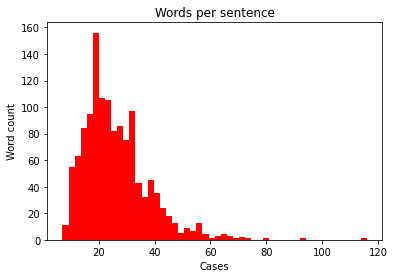

In [11]:
#Count words per sentence so we can set an appropiate max_len. In this case, 200 will be more than enough.
word_list = [len(x.split()) for x in df["clean_text"].tolist()]
fig = plt.figure()
ax = fig.add_subplot(1,1,1,)
n, bins, patches = ax.hist(word_list, bins=50, histtype='bar')

#ax.set_xticklabels([n], rotation='vertical')

for patch in patches:
    patch.set_facecolor('r')

plt.title("Words per sentence")
plt.xlabel('Cases')
plt.ylabel('Word count')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


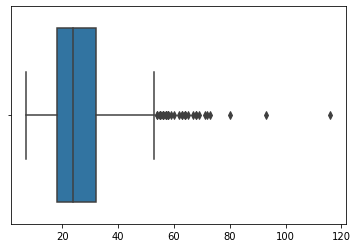

In [12]:
sns.boxplot(word_list)

In [13]:
np.count_nonzero(np.array(word_list) >= 75)
#maximum length of 75 is fine!

#recheck this after removing start-cite, end-cite etc

3

# Valentin tries with Keras

In [14]:
#lets turn "accept" into a column that properly lists the labels (right now it is a string of a list instead of a list of strings)
rejoined = np.array([row.split(" ") for row in df.labels_str])
df["accept"] = rejoined
df_new = df[["clean_text", "accept"]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [15]:
rejoined

array([list(['Data']), list(['Definition']), list(['Method', 'Theory']),
       ..., list(['Definition']), list(['RelationToLiterature']),
       list(['Definition'])], dtype=object)

In [16]:
df_new = df_new.reset_index().drop(columns = "index")
df_new.columns = ["text", "label"]

In [17]:
# First Split for Train and Test
#we should stratify, but we have some groups that have only one
train_df, test_df = train_test_split(df_new, test_size=0.3, random_state= 0)#, stratify = df_new.label.values)

# Next split test in to test and validation
val_df = test_df.sample(frac = 0.667)
test_df = test_df.drop(val_df.index)

#70% train, 20% val, 10% test
print(train_df.shape[0], val_df.shape[0], test_df.shape[0])

897 257 128


In [18]:
#encoding labels with keras Lookup Layer
terms = tf.ragged.constant(df_new["label"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

print(f"Vocabulary: {vocab}")
#the UNK token will always also be returned.

Vocabulary: ['[UNK]', 'RelationToLiterature', 'Theory', 'Method', 'EmpiricalResult', 'Definition', 'Contribution', 'Motivation', 'Data', 'HypothesisResult', 'Goal', 'Limitation', 'FutureWork', 'Item', 'Hypothesis', 'ResearchQuestion']


In [19]:
#Example
sample_label = df_new["label"].iloc[2]
label_binarized = lookup([sample_label])
label_binarized, sample_label
#Note: Unlike the OHE with sklearn, this is not ordered alphabetically but in the order we can find below (including the UNK token)

(<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
 array([[0.000000, 0.000000, 1.000000, 1.000000, 0.000000, 0.000000,
         0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
         0.000000, 0.000000, 0.000000, 0.000000]], dtype=float32)>,
 ['Method', 'Theory'])

Inspo:
 
https://www.kaggle.com/code/samarthagarwal23/0-81-tf-keras-deberta-baseline-single-model

https://keras.io/examples/nlp/multi_label_classification/ 

In [20]:
#Our Config (so we can reference this values in later code and avoid spaghetti)
seed = 0
epochs = 10
#num_folds = 5, #set folds later on
max_length = 75
batch_size = 8
learning_rate = 2e-5
base_model = "bert-large-uncased"

In [21]:
#Prepare tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model)
def tok(x): return tokenizer(x, padding = True, truncation = True, return_tensors = "tf", max_length = max_length)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [22]:
def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["label"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        #because tokenizing becomes more dificult afterwards (hugginface clashes a little with keras), I already tokenize here
        ((tok(list(dataframe.text))["input_ids"], tok(list(dataframe.text))["attention_mask"])
        #not using the token type since we are not using special tokens anyways
        ,label_binarized)
    )
    #take batches randomly along the whole dataset
    dataset = dataset.shuffle(batch_size * ((dataframe.shape[0] // batch_size) + 1)) if is_train else dataset
    return dataset.batch(batch_size)

In [23]:
#get datasets
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [24]:
def get_labels_out(dataset):
    labels = []
    for element in dataset:
        for arr in element[1]:
            labels.append(np.array(arr))
    labels = np.asarray(labels)
    return labels

In [25]:
#One example input and (decoded) output from the train dataset
text_batch, label_batch = next(iter(train_dataset))
for i, text in enumerate(text_batch[0][:3]):
    label = label_batch[i].numpy()
    print(f"Tokens: {text}")
    print(f"Label(s): {invert_multi_hot(label)}")
#the first three will be our input

Tokens: [  101  2951 16283  6806 18161  2003  1037  2974  2007  2714  6459  1006
  1999  8202  1010  2727  1007  1012   102     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
Label(s): ['RelationToLiterature' 'Definition']
Tokens: [ 101 1996 7660 2165 2173 1999 3699 1010 1998 1045 2499 2045 2127 3380
 1010 2011 2029 2051 6688 3523 2001 1999 3169 1012  102    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
Label(s): ['Item']
Tokens: [  101  1996  3330  2568  1011  2275  2003  4180  2007  4346  1037  1

In [26]:
def build_model():
    
    input_ids = tf.keras.Input(shape=(max_length, ), dtype = tf.int32)
    input_mask = tf.keras.Input(shape=(max_length, ), dtype = tf.int32)
    
    bert = transformers.TFAutoModel.from_pretrained(base_model, num_labels=15, problem_type="multi_label", trainable=True)
    x = bert(input_ids = input_ids, attention_mask = input_mask)

    #this is fore finetuning (tinkering with last layers)
    x = tf.keras.layers.GlobalAveragePooling1D()(x.last_hidden_state)
    x = tf.keras.layers.Dropout(0.1)(x)
    fnl = tf.keras.layers.Dense(lookup.vocabulary_size(), activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs = [input_ids, input_mask], 
                           outputs = fnl)
    return model


In [27]:
model = build_model()
model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
        loss = "binary_crossentropy",
        metrics=["categorical_accuracy"],
    )

Downloading:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [28]:
callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', 
                                               patience=2,
                                               mode='max', 
                                               verbose=1,
                                               restore_best_weights=True)
callback_save = tf.keras.callbacks.ModelCheckpoint(
        'setencebert.h5', monitor='val_categorical_accuracy', 
        verbose=1, save_best_only=True,
        save_weights_only=True, mode='max', 
        save_freq='epoch')

In [29]:
model.fit(train_dataset, 
        epochs = 10,
        shuffle=True,
        callbacks = [#callback_lr,,
                      callback_es,
                      callback_save,
                     ],
        batch_size = 8,
        validation_data= validation_dataset
       )
#Note: Bert-Base (used to set up the trainer) early stopped after 7 epochs with a max val_acc of 47%

Epoch 1/10
113/113 [==============================] - ETA: 0s - loss: 0.2632 - categorical_accuracy: 0.3010
Epoch 1: val_categorical_accuracy improved from -inf to 0.38132, saving model to setencebert.h5
113/113 [==============================] - 96s 580ms/step - loss: 0.2632 - categorical_accuracy: 0.3010 - val_loss: 0.2258 - val_categorical_accuracy: 0.3813
Epoch 2/10
113/113 [==============================] - ETA: 0s - loss: 0.2149 - categorical_accuracy: 0.4805
Epoch 2: val_categorical_accuracy improved from 0.38132 to 0.41245, saving model to setencebert.h5
113/113 [==============================] - 63s 556ms/step - loss: 0.2149 - categorical_accuracy: 0.4805 - val_loss: 0.2221 - val_categorical_accuracy: 0.4125
Epoch 3/10
113/113 [==============================] - ETA: 0s - loss: 0.1692 - categorical_accuracy: 0.6076
Epoch 3: val_categorical_accuracy improved from 0.41245 to 0.46304, saving model to setencebert.h5
113/113 [==============================] - 62s 549ms/step - loss: 

In [33]:
preds = model.predict(test_dataset)
#preds[preds>=0.5] = 1
#preds[preds<0.5] = 0

In [34]:
test_labels = get_labels_out(test_dataset)

In [35]:
for i, labels in enumerate(test_labels[:5]):
    print(f"index {i}: \n predictions: \n {preds[i]} \n real labels: \n {test_labels[i]}")

#with bert base:
#0 is perfect
#1 has a too low threshold (max is on right index but only at .39)
#2 did a bad prediction (low values for real values and very high for a different one)
#3 is perfect (with label "2" being kind of high with .22 (although it should be 0))
#4 only identified one of two labels (label "9" has value .22 (although it should be 1))

#with bert large:
#0 is just short of threshold
#1 only spotted one of the 3 labels, one label has high values (0.3) although it should be 0
#2 is perfeect
#3 is perfect
#4 did really bad, seems unsure between 6 labels, real label has low value (.17)

index 0: 
 predictions: 
 [0.000917 0.057630 0.208022 0.456547 0.006967 0.001735 0.006767 0.018919
 0.000555 0.001519 0.017247 0.137238 0.050414 0.004106 0.005772 0.008006] 
 real labels: 
 [0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000]
index 1: 
 predictions: 
 [0.000834 0.041843 0.576713 0.005677 0.031713 0.304200 0.009681 0.008004
 0.000567 0.011831 0.015890 0.001968 0.008606 0.001112 0.076263 0.045502] 
 real labels: 
 [0.000000 1.000000 1.000000 0.000000 1.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000]
index 2: 
 predictions: 
 [0.001657 0.010344 0.043954 0.047421 0.951545 0.002986 0.081901 0.009292
 0.007844 0.023965 0.001020 0.162963 0.061679 0.001509 0.102950 0.003591] 
 real labels: 
 [0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000

# Inference

# Retrain with new params

# Re-Inference